# BlackJack : Monte-Carlo with Exploring Start
----

## 설명
블랙잭 게임에서의 최적 Policy를 찾는 프로그램입니다. 본 프로그램에서 정의된 블랙잭 룰은 다음과 같습니다.
 - 하나의 카드 덱(조커를 제외한 52장의 카드)을 사용
 - 카드의 합을 계산할 시 A = 1 or 11, J,Q,K = 10으로 계산
 - 플레이어는 Hit 또는 Stick만을 할 수 있음
 - 카드의 합이 21 이하일 경우, 딜러와 플레이어 중 숫자가 더 높은 쪽이 승리.
 - 카드의 합이 21 초과한 딜러/플레이어는 패배
 - 카드의 합이 같을 경우 무승부

본 프로그램에서는 최적 Policy를 찾기 위해 Monte-Carlo Control with Exploring Start[1] 알고리즘을 사용합니다. 최적 Policy를 찾기 위해, 본 프로그램은 다음과 같은 변수로 구성된 State로부터 탐색을 수행합니다.
 - 플레이어 카드의 합 : 12 ~ 21 사이의 정수
 - 딜러가 보여주는 카드의 숫자 : 1 ~ 10 사이의 정수
 - 플레이어가 현재 사용 가능한 Ace의 유무 : True / False

위와 같이 구성된 State S에서 Action A를 선택했을 때의 기대 리턴(게임이 끝났을 때 얻을 것으로 기대되는 보상의 합)은 Q(S,A)입니다. 많은 에피소드를 경험할수혹 Agent는 Optimal Q(S,A)에 가까운 값을 학습하게 되며, 이로부터 최적 Policy를 찾을 수 있습니다.

----

## 0. Package
먼저 본 프로그램에서 사용할 Package를 Import합니다.

In [2]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## 1. Class : Deck
카드 덱 한 벌에 해당하는 클래스를 선언합니다. 조커를 제외한 52장의 카드로 이루어져 있으며, 각 카드는 정수로 표기됩니다. <br>
A = 11, J, Q, K = 10으로 표현되며, 나머지 카드는 해당 카드에 적힌 숫자만큼의 값을 갖습니다.

### 클래스 구성
* Attributes
   * card_deck : List, 52개의 정수로 이루어짐
* Methods
   * shuffle() : 카드 덱을 랜덤하게 섞음
   * draw() : 카드 덱에서 한 장을 뽑아 리턴
   * reset() : 카드 덱을 초기화함

In [3]:
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """

    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        return self.card_deck.pop()

    def reset(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

## 2. Class : Dealer
다음으로 Dealer 클래스를 선언합니다.<br> 
Dealer 클래스는 강화학습에서의 Environment에 해당합니다. 플레이어의 Action을 받고, 그에 따른 다음 State와 Reward를 반환합니다.<br>
딜러는 시작할 때 두 장의 카드를 받습니다. 플레이어의 차례가 끝난 후, 플레이어의 카드 합이 21을 넘지 않는다면 딜러는 다음과 같이 행동합니다.
 - 딜러 카드의 합이 17 미만일 때 : 카드 한 장을 추가로 뽑음 (Hit)
 - 딜러 카드의 합이 17 이상일 때 : 플레이어의 카드 합과 비교하여 승패 결정 (Stick)

### 클래스 구성
딜러 클래스는 다음과 같이 구성됩니다
 - Attributes
     - hands : List, 딜러가 가지고 있는 카드들
     - usable_ace : List, 딜러가 가지고 있는 A의 인덱스
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - show() : 딜러가 가진 카드 중 랜덤한 한 장의 값을 리턴
     - calculate_sum() : 딜러가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - action() : 딜러의 Action - 합이 17 미만이면 hit, 이상이면 stick
     - observation(action, agent, deck) : 플레이어의 action을 받아 종료 여부와 reward 리턴
     - calculate_rewards(agent, deck) : 플레이어와 딜러의 승패 계산 및 reward 리턴
     - reset() : 딜러 클래스의 모든 attribute 초기화

In [4]:
class Dealer(object):
    """
    Dealer : 딜러 클래스
    딜러는 두 장의 카드를 받고, 카드의 합이 16 이하이면 Hit, 17이상이면 Stick 함.
    처음 두 장을 받았을 때 한 장의 카드를 랜덤하게 오픈함.
    """

    def __init__(self):
        """
        hand : 딜러가 가진 카드
        usable_ace : 딜러가 가진 카드 리스트 중 ace의 인덱스
        natural : 두 장의 카드로 21이 되면 True, 아니면 False
        """
        self.hands = list()
        self.usable_ace = list()

    def hit(self, deck: Deck):
        """
        딜러의 Hit. 새로운 카드가 Ace라면 사용 가능한 Ace 리스트에 추가함
        :param deck: Deck Object
        :return:
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def show(self):
        """
        딜러가 가진 카드 중 하나를 랜덤하게 보여줌
        :return: 딜러의 카드 중 랜덤한 카드 숫자
        """
        card = random.choice(self.hands)
        if card == 11:
            card = 1
        return card

    def calculate_sum(self):
        """
        딜러가 가진 카드의 합을 구함
        21을 넘을 때 사용 가능한 Ace가 있으면 사용함
        :return: 딜러 카드의 합
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def action(self, deck: Deck):
        """
        딜러의 순서 때 딜러의 행동.
        숫자의 합이 16 이하일 때는 Hit, 17 이상이면 Stick
        :param deck:
        :return:
        """
        while True:
            sums = self.calculate_sum()
            if sums < 17:
                self.hit(deck)
            else:
                return sums

    def observation(self, action, agent, deck):
        """
        플레이어의 Action을 받아, 그에 맞는 Observation과 Reward를 반환
        :param action: agent 의 Action
        :param agent: agent 클래스
        :param deck: deck 클래스
        :return: 에피소드 종료 여부, reward
        """
        done = False
        reward = 0
        if action == True:  # Hit
            agent.hit(deck)
            if agent.calculate_sum() > 21:  #플레이어의 Hit으로 인해 카드 합이 21이 넘으면 즉시 종료
                done = True
                reward = -1
        else:  # Stick
            done = True
            reward = self.calcuate_reward(agent, deck)

        return done, reward

    def calcuate_reward(self, agent, deck):
        """
        플레이어가 Stick했을 때 딜러와의 카드 비교 수행
        :param agent:
        :param deck:
        :return: Reward
        """
        agent_sum = agent.calculate_sum()           # 플레이어의 카드 합 계산
        if agent_sum > 21:                          # 플레이어의 Bust (패)
            return -1

        dealer_sum = self.action(deck)              # 딜러의 카드 합 계산
        if dealer_sum > 21:                         # 딜러가 Bust (승)
            return 1
        if dealer_sum > agent_sum:                  # 딜러의 카드 합 > 플레이어 합 (패)
            return -1
        if dealer_sum < agent_sum:                  # 딜러의 카드 합 < 플레이어 합 (승)
            return 1
        return 0                                   # 딜러의 카드 합 == 플레이어의 합 (무)

    def reset(self):
        """
        딜러 초기화 (새로운 에피소드 시작을 위해)
        """
        self.hands = list()
        self.usable_ace = list()

## 3. Class : Agent
Agent 클래스는 플레이어에 해당하며, 최적 Policy를 학습하는 주체가 됩니다. Agent는 여러 에피소드들로부터 Q값(기대 Return)을 계산하고, 다음 에피소드 수행 시 해당 State에서 Q값이 높은 Action을 선택하는 Greedy Policy를 따릅니다. 

### 클래스 구성

Agent의 구성은 다음과 같습니다.

 - Attributes
     - hands : List, Agent가 가지고 있는 카드들
     - usable_ace : List, Agent가 가지고 있는 A의 인덱스
     - Q_table : Dictionary, 기대 Return값과 방문 횟수를 저장
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - calculate_sum() : Agent가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - random_action() : 현재 State에 상관없이 랜덤하게 Action을 리턴
     - policy(state) : 현재 State에서 가능한 Action 중, Q_table의 값이 큰 Action을 리턴
     - update_qval(episode) : 에피소드로부터 평균 리턴을 계산하여 Q_table을 업데이트
     - reset() : Agent 클래스의 모든 attribute 초기화

In [15]:
class Agent(object):
    def __init__(self):
        """
        hand : 플레이어의 카드
        usable_ace : 사용 가능한 ace 리스트
        Q_table : q(s,a) 값을 저장할 딕셔너리
        """
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()
        self.winrate=0
        self.M_table = list()

    def hit(self, deck: Deck):
        """
        덱에서 새로운 카드를 뽑음
        :param deck: Deck for draw a card
        :return: None
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def calculate_sum(self):
        """
        플레이어가 가진 카드의 합을 구함.
        21을 넘을 때 사용 가능한 ace가 있으면 사용함
        :return:
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def random_action(self):
        """
        랜덤하게 행동
        True = hit, False = stick
        :return:
        """
        return random.choice([True, False])

    def policy(self, state):
        """
        Agent의 policy 함수.
        e의 확률로 랜덤 행동을 하며, 그 외에는 현재 state에서 큰 q(s,a)값을 갖는 action을 선택함
        :param state: Agent에게 주어진 state
        :return: agent의 action을 반환 , True = hit and False = stick
        """
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in (True, False):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue

        # q값이 큰 action 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)]:
            return True     # Hit
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)]:   # q값이 같으면 무작위추출
            return self.random_action()
        else:
            return False    # Stick


    def reset(self):
        """
        Agent를 리셋함
        :return: None
        """
        self.hands = list()
        self.usable_ace = list()

    def update_qval(self, episode):
        """
        에피소드(한 번의 게임)으로부터 Q_table 을 업데이트함
        Q 테이블에 없는 state-action 쌍이 나오면 새로 생성
        Q 테이블에 state-action 쌍이 존재한다면 Incremental mean 적용하여 업데이트
        :param episode: Episode generated from environment
        :return: None
        """
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트
                
    



## 4. Class : MonteCarlo
Monte-Carlo control with Exploring Start를 구현한 클래스입니다. 에피소드를 생성할 수 있고, 생성된 에피소드로부터 에이전트를 학습시킵니다.
에피소드 생성 시 Exploring Start를 위해 에피소드의 첫 번째 State에서는 무작위로 Action을 선택하며, 이후에는 에이전트의 Policy를 따라 Action을 선택합니다.

### 클래스 구성
MonteCarlo 클래스는 다음과 같이 구성됩니다.
 - Attribute
     - 없음
 - Methods 
     - generate_episode(dealer, agent, deck) : 딜러, 플레이어, 카드 덱을 이용해 한 번의 블랙잭 게임을 진행하고 에피소드를 반환합니다.
     - train(dealer, agent, deck, it, verbose) : 지정된 이터레이션 수만큼의 에피소드로부터 플레이어를 학습시킵니다.

In [17]:
class MonteCarlo(object):
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            state = (sums, bool(agent.usable_ace), dealer.show())

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action =agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        return episode

    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it=10000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
                
                
                #실제 게임을 위한 함수, 초기 돈 10000, policy 업데이트 X 기존을 사용만 한다.
                
    def realgame (self, dealer: Dealer, agent: Agent, deck: Deck, it=1000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        
        agent.winrate =0
        agent.M_table().clear() #Agent 의 자금 table을 초기화
        money= 10000
        
        result = str()
        for i in range(it):
            count += 1
            agent.M_table.append(money)
            money = money - 10
            episode = self.generate_episode(dealer, agent, deck)
            
        

            if episode[-1][-1] == 1:
                win += 1
                money += 20
            elif episode[-1][-1] == 0:
                draw += 1
                money += 10
            else:
                loss += 1

            if count % 100 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 100 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 100 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print("Agent's Current Money :",money)
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)
                
            agent.winrate = win / (win + loss) * 100
    
                

## 5. Function : plot_q_val(agent, usable_ace)
Q값을 시각화하기 위한 함수입니다.

In [7]:
def plot_q_val(agent: Agent, usable_ace=True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

## 6. Function : plot_q_val(agent, usable_ace)
최적 Policy를 시각화하기 위한 함수입니다.

In [8]:
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.show()
    return X, Y, Z

## 7. 최적 Policy 학습


In [9]:
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it=1000000)

========== Training : Episode  1000  ===========
Recent 1000 games win rate :36.315%
 -- 1000 Games WIN : 341 DRAW : 61 LOSS : 598
Total win rate : 36.315%
 -- TOTAL Games WIN : 341 DRAW : 61 LOSS : 598
========== Training : Episode  2000  ===========
Recent 1000 games win rate :37.076%
 -- 1000 Games WIN : 350 DRAW : 56 LOSS : 594
Total win rate : 36.697%
 -- TOTAL Games WIN : 691 DRAW : 117 LOSS : 1192
========== Training : Episode  3000  ===========
Recent 1000 games win rate :34.115%
 -- 1000 Games WIN : 320 DRAW : 62 LOSS : 618
Total win rate : 35.838%
 -- TOTAL Games WIN : 1011 DRAW : 179 LOSS : 1810
========== Training : Episode  4000  ===========
Recent 1000 games win rate :33.513%
 -- 1000 Games WIN : 311 DRAW : 72 LOSS : 617
Total win rate : 35.263%
 -- TOTAL Games WIN : 1322 DRAW : 251 LOSS : 2427
========== Training : Episode  5000  ===========
Recent 1000 games win rate :34.958%
 -- 1000 Games WIN : 330 DRAW : 56 LOSS : 614
Total win rate : 35.201%
 -- TOTAL Games WIN : 16

========== Training : Episode  41000  ===========
Recent 1000 games win rate :34.461%
 -- 1000 Games WIN : 326 DRAW : 54 LOSS : 620
Total win rate : 35.319%
 -- TOTAL Games WIN : 13644 DRAW : 2369 LOSS : 24987
========== Training : Episode  42000  ===========
Recent 1000 games win rate :33.477%
 -- 1000 Games WIN : 311 DRAW : 71 LOSS : 618
Total win rate : 35.276%
 -- TOTAL Games WIN : 13955 DRAW : 2440 LOSS : 25605
========== Training : Episode  43000  ===========
Recent 1000 games win rate :34.549%
 -- 1000 Games WIN : 322 DRAW : 68 LOSS : 610
Total win rate : 35.259%
 -- TOTAL Games WIN : 14277 DRAW : 2508 LOSS : 26215
========== Training : Episode  44000  ===========
Recent 1000 games win rate :37.527%
 -- 1000 Games WIN : 352 DRAW : 62 LOSS : 586
Total win rate : 35.310%
 -- TOTAL Games WIN : 14629 DRAW : 2570 LOSS : 26801
========== Training : Episode  45000  ===========
Recent 1000 games win rate :34.372%
 -- 1000 Games WIN : 320 DRAW : 69 LOSS : 611
Total win rate : 35.290%
 --

 -- 1000 Games WIN : 327 DRAW : 60 LOSS : 613
Total win rate : 35.470%
 -- TOTAL Games WIN : 28060 DRAW : 4890 LOSS : 51050
========== Training : Episode  85000  ===========
Recent 1000 games win rate :33.580%
 -- 1000 Games WIN : 318 DRAW : 53 LOSS : 629
Total win rate : 35.447%
 -- TOTAL Games WIN : 28378 DRAW : 4943 LOSS : 51679
========== Training : Episode  86000  ===========
Recent 1000 games win rate :34.690%
 -- 1000 Games WIN : 324 DRAW : 66 LOSS : 610
Total win rate : 35.439%
 -- TOTAL Games WIN : 28702 DRAW : 5009 LOSS : 52289
========== Training : Episode  87000  ===========
Recent 1000 games win rate :33.582%
 -- 1000 Games WIN : 315 DRAW : 62 LOSS : 623
Total win rate : 35.417%
 -- TOTAL Games WIN : 29017 DRAW : 5071 LOSS : 52912
========== Training : Episode  88000  ===========
Recent 1000 games win rate :36.530%
 -- 1000 Games WIN : 339 DRAW : 72 LOSS : 589
Total win rate : 35.430%
 -- TOTAL Games WIN : 29356 DRAW : 5143 LOSS : 53501
========== Training : Episode  89000

========== Training : Episode  127000  ===========
Recent 1000 games win rate :34.322%
 -- 1000 Games WIN : 324 DRAW : 56 LOSS : 620
Total win rate : 35.467%
 -- TOTAL Games WIN : 42360 DRAW : 7565 LOSS : 77075
========== Training : Episode  128000  ===========
Recent 1000 games win rate :35.608%
 -- 1000 Games WIN : 334 DRAW : 62 LOSS : 604
Total win rate : 35.468%
 -- TOTAL Games WIN : 42694 DRAW : 7627 LOSS : 77679
========== Training : Episode  129000  ===========
Recent 1000 games win rate :35.075%
 -- 1000 Games WIN : 329 DRAW : 62 LOSS : 609
Total win rate : 35.465%
 -- TOTAL Games WIN : 43023 DRAW : 7689 LOSS : 78288
========== Training : Episode  130000  ===========
Recent 1000 games win rate :34.889%
 -- 1000 Games WIN : 329 DRAW : 57 LOSS : 614
Total win rate : 35.461%
 -- TOTAL Games WIN : 43352 DRAW : 7746 LOSS : 78902
========== Training : Episode  131000  ===========
Recent 1000 games win rate :36.461%
 -- 1000 Games WIN : 342 DRAW : 62 LOSS : 596
Total win rate : 35.468

========== Training : Episode  168000  ===========
Recent 1000 games win rate :36.538%
 -- 1000 Games WIN : 342 DRAW : 64 LOSS : 594
Total win rate : 35.525%
 -- TOTAL Games WIN : 56124 DRAW : 10017 LOSS : 101859
========== Training : Episode  169000  ===========
Recent 1000 games win rate :35.487%
 -- 1000 Games WIN : 335 DRAW : 56 LOSS : 609
Total win rate : 35.525%
 -- TOTAL Games WIN : 56459 DRAW : 10073 LOSS : 102468
========== Training : Episode  170000  ===========
Recent 1000 games win rate :33.475%
 -- 1000 Games WIN : 315 DRAW : 59 LOSS : 626
Total win rate : 35.513%
 -- TOTAL Games WIN : 56774 DRAW : 10132 LOSS : 103094
========== Training : Episode  171000  ===========
Recent 1000 games win rate :38.182%
 -- 1000 Games WIN : 357 DRAW : 65 LOSS : 578
Total win rate : 35.529%
 -- TOTAL Games WIN : 57131 DRAW : 10197 LOSS : 103672
========== Training : Episode  172000  ===========
Recent 1000 games win rate :36.598%
 -- 1000 Games WIN : 340 DRAW : 71 LOSS : 589
Total win rate 

========== Training : Episode  210000  ===========
Recent 1000 games win rate :35.970%
 -- 1000 Games WIN : 341 DRAW : 52 LOSS : 607
Total win rate : 35.565%
 -- TOTAL Games WIN : 70214 DRAW : 12578 LOSS : 127208
========== Training : Episode  211000  ===========
Recent 1000 games win rate :34.921%
 -- 1000 Games WIN : 330 DRAW : 55 LOSS : 615
Total win rate : 35.562%
 -- TOTAL Games WIN : 70544 DRAW : 12633 LOSS : 127823
========== Training : Episode  212000  ===========
Recent 1000 games win rate :37.434%
 -- 1000 Games WIN : 353 DRAW : 57 LOSS : 590
Total win rate : 35.571%
 -- TOTAL Games WIN : 70897 DRAW : 12690 LOSS : 128413
========== Training : Episode  213000  ===========
Recent 1000 games win rate :36.938%
 -- 1000 Games WIN : 345 DRAW : 66 LOSS : 589
Total win rate : 35.578%
 -- TOTAL Games WIN : 71242 DRAW : 12756 LOSS : 129002
========== Training : Episode  214000  ===========
Recent 1000 games win rate :34.611%
 -- 1000 Games WIN : 325 DRAW : 61 LOSS : 614
Total win rate 

========== Training : Episode  251000  ===========
Recent 1000 games win rate :35.453%
 -- 1000 Games WIN : 329 DRAW : 72 LOSS : 599
Total win rate : 35.579%
 -- TOTAL Games WIN : 83921 DRAW : 15125 LOSS : 151954
========== Training : Episode  252000  ===========
Recent 1000 games win rate :36.161%
 -- 1000 Games WIN : 341 DRAW : 57 LOSS : 602
Total win rate : 35.581%
 -- TOTAL Games WIN : 84262 DRAW : 15182 LOSS : 152556
========== Training : Episode  253000  ===========
Recent 1000 games win rate :36.797%
 -- 1000 Games WIN : 347 DRAW : 57 LOSS : 596
Total win rate : 35.586%
 -- TOTAL Games WIN : 84609 DRAW : 15239 LOSS : 153152
========== Training : Episode  254000  ===========
Recent 1000 games win rate :36.067%
 -- 1000 Games WIN : 343 DRAW : 49 LOSS : 608
Total win rate : 35.588%
 -- TOTAL Games WIN : 84952 DRAW : 15288 LOSS : 153760
========== Training : Episode  255000  ===========
Recent 1000 games win rate :37.500%
 -- 1000 Games WIN : 351 DRAW : 64 LOSS : 585
Total win rate 

========== Training : Episode  292000  ===========
Recent 1000 games win rate :35.957%
 -- 1000 Games WIN : 338 DRAW : 60 LOSS : 602
Total win rate : 35.545%
 -- TOTAL Games WIN : 97539 DRAW : 17593 LOSS : 176868
========== Training : Episode  293000  ===========
Recent 1000 games win rate :36.422%
 -- 1000 Games WIN : 342 DRAW : 61 LOSS : 597
Total win rate : 35.548%
 -- TOTAL Games WIN : 97881 DRAW : 17654 LOSS : 177465
========== Training : Episode  294000  ===========
Recent 1000 games win rate :33.757%
 -- 1000 Games WIN : 319 DRAW : 55 LOSS : 626
Total win rate : 35.542%
 -- TOTAL Games WIN : 98200 DRAW : 17709 LOSS : 178091
========== Training : Episode  295000  ===========
Recent 1000 games win rate :32.435%
 -- 1000 Games WIN : 301 DRAW : 72 LOSS : 627
Total win rate : 35.532%
 -- TOTAL Games WIN : 98501 DRAW : 17781 LOSS : 178718
========== Training : Episode  296000  ===========
Recent 1000 games win rate :35.225%
 -- 1000 Games WIN : 329 DRAW : 66 LOSS : 605
Total win rate 

========== Training : Episode  335000  ===========
Recent 1000 games win rate :34.382%
 -- 1000 Games WIN : 328 DRAW : 46 LOSS : 626
Total win rate : 35.530%
 -- TOTAL Games WIN : 111869 DRAW : 20142 LOSS : 202989
========== Training : Episode  336000  ===========
Recent 1000 games win rate :37.092%
 -- 1000 Games WIN : 352 DRAW : 51 LOSS : 597
Total win rate : 35.535%
 -- TOTAL Games WIN : 112221 DRAW : 20193 LOSS : 203586
========== Training : Episode  337000  ===========
Recent 1000 games win rate :34.947%
 -- 1000 Games WIN : 332 DRAW : 50 LOSS : 618
Total win rate : 35.533%
 -- TOTAL Games WIN : 112553 DRAW : 20243 LOSS : 204204
========== Training : Episode  338000  ===========
Recent 1000 games win rate :37.540%
 -- 1000 Games WIN : 351 DRAW : 65 LOSS : 584
Total win rate : 35.539%
 -- TOTAL Games WIN : 112904 DRAW : 20308 LOSS : 204788
========== Training : Episode  339000  ===========
Recent 1000 games win rate :36.335%
 -- 1000 Games WIN : 343 DRAW : 56 LOSS : 601
Total win r

========== Training : Episode  377000  ===========
Recent 1000 games win rate :34.571%
 -- 1000 Games WIN : 326 DRAW : 57 LOSS : 617
Total win rate : 35.554%
 -- TOTAL Games WIN : 125995 DRAW : 22619 LOSS : 228386
========== Training : Episode  378000  ===========
Recent 1000 games win rate :35.515%
 -- 1000 Games WIN : 331 DRAW : 68 LOSS : 601
Total win rate : 35.553%
 -- TOTAL Games WIN : 126326 DRAW : 22687 LOSS : 228987
========== Training : Episode  379000  ===========
Recent 1000 games win rate :34.936%
 -- 1000 Games WIN : 327 DRAW : 64 LOSS : 609
Total win rate : 35.552%
 -- TOTAL Games WIN : 126653 DRAW : 22751 LOSS : 229596
========== Training : Episode  380000  ===========
Recent 1000 games win rate :36.606%
 -- 1000 Games WIN : 343 DRAW : 63 LOSS : 594
Total win rate : 35.555%
 -- TOTAL Games WIN : 126996 DRAW : 22814 LOSS : 230190
========== Training : Episode  381000  ===========
Recent 1000 games win rate :37.140%
 -- 1000 Games WIN : 348 DRAW : 63 LOSS : 589
Total win r

========== Training : Episode  421000  ===========
Recent 1000 games win rate :35.692%
 -- 1000 Games WIN : 338 DRAW : 53 LOSS : 609
Total win rate : 35.555%
 -- TOTAL Games WIN : 140706 DRAW : 25262 LOSS : 255032
========== Training : Episode  422000  ===========
Recent 1000 games win rate :33.548%
 -- 1000 Games WIN : 312 DRAW : 70 LOSS : 618
Total win rate : 35.551%
 -- TOTAL Games WIN : 141018 DRAW : 25332 LOSS : 255650
========== Training : Episode  423000  ===========
Recent 1000 games win rate :36.786%
 -- 1000 Games WIN : 348 DRAW : 54 LOSS : 598
Total win rate : 35.554%
 -- TOTAL Games WIN : 141366 DRAW : 25386 LOSS : 256248
========== Training : Episode  424000  ===========
Recent 1000 games win rate :35.086%
 -- 1000 Games WIN : 327 DRAW : 68 LOSS : 605
Total win rate : 35.552%
 -- TOTAL Games WIN : 141693 DRAW : 25454 LOSS : 256853
========== Training : Episode  425000  ===========
Recent 1000 games win rate :36.055%
 -- 1000 Games WIN : 340 DRAW : 57 LOSS : 603
Total win r

========== Training : Episode  465000  ===========
Recent 1000 games win rate :33.792%
 -- 1000 Games WIN : 319 DRAW : 56 LOSS : 625
Total win rate : 35.579%
 -- TOTAL Games WIN : 155497 DRAW : 27958 LOSS : 281545
========== Training : Episode  466000  ===========
Recent 1000 games win rate :31.144%
 -- 1000 Games WIN : 294 DRAW : 56 LOSS : 650
Total win rate : 35.570%
 -- TOTAL Games WIN : 155791 DRAW : 28014 LOSS : 282195
========== Training : Episode  467000  ===========
Recent 1000 games win rate :34.144%
 -- 1000 Games WIN : 323 DRAW : 54 LOSS : 623
Total win rate : 35.567%
 -- TOTAL Games WIN : 156114 DRAW : 28068 LOSS : 282818
========== Training : Episode  468000  ===========
Recent 1000 games win rate :33.298%
 -- 1000 Games WIN : 313 DRAW : 60 LOSS : 627
Total win rate : 35.562%
 -- TOTAL Games WIN : 156427 DRAW : 28128 LOSS : 283445
========== Training : Episode  469000  ===========
Recent 1000 games win rate :33.904%
 -- 1000 Games WIN : 317 DRAW : 65 LOSS : 618
Total win r

========== Training : Episode  505000  ===========
Recent 1000 games win rate :36.093%
 -- 1000 Games WIN : 340 DRAW : 58 LOSS : 602
Total win rate : 35.560%
 -- TOTAL Games WIN : 168786 DRAW : 30353 LOSS : 305861
========== Training : Episode  506000  ===========
Recent 1000 games win rate :35.138%
 -- 1000 Games WIN : 331 DRAW : 58 LOSS : 611
Total win rate : 35.559%
 -- TOTAL Games WIN : 169117 DRAW : 30411 LOSS : 306472
========== Training : Episode  507000  ===========
Recent 1000 games win rate :31.979%
 -- 1000 Games WIN : 299 DRAW : 65 LOSS : 636
Total win rate : 35.552%
 -- TOTAL Games WIN : 169416 DRAW : 30476 LOSS : 307108
========== Training : Episode  508000  ===========
Recent 1000 games win rate :41.461%
 -- 1000 Games WIN : 386 DRAW : 69 LOSS : 545
Total win rate : 35.564%
 -- TOTAL Games WIN : 169802 DRAW : 30545 LOSS : 307653
========== Training : Episode  509000  ===========
Recent 1000 games win rate :37.161%
 -- 1000 Games WIN : 356 DRAW : 42 LOSS : 602
Total win r

========== Training : Episode  548000  ===========
Recent 1000 games win rate :38.445%
 -- 1000 Games WIN : 366 DRAW : 48 LOSS : 586
Total win rate : 35.534%
 -- TOTAL Games WIN : 183027 DRAW : 32925 LOSS : 332048
========== Training : Episode  549000  ===========
Recent 1000 games win rate :35.722%
 -- 1000 Games WIN : 334 DRAW : 65 LOSS : 601
Total win rate : 35.534%
 -- TOTAL Games WIN : 183361 DRAW : 32990 LOSS : 332649
========== Training : Episode  550000  ===========
Recent 1000 games win rate :35.897%
 -- 1000 Games WIN : 336 DRAW : 64 LOSS : 600
Total win rate : 35.535%
 -- TOTAL Games WIN : 183697 DRAW : 33054 LOSS : 333249
========== Training : Episode  551000  ===========
Recent 1000 games win rate :34.490%
 -- 1000 Games WIN : 318 DRAW : 78 LOSS : 604
Total win rate : 35.533%
 -- TOTAL Games WIN : 184015 DRAW : 33132 LOSS : 333853
========== Training : Episode  552000  ===========
Recent 1000 games win rate :36.451%
 -- 1000 Games WIN : 343 DRAW : 59 LOSS : 598
Total win r

========== Training : Episode  587000  ===========
Recent 1000 games win rate :35.895%
 -- 1000 Games WIN : 341 DRAW : 50 LOSS : 609
Total win rate : 35.518%
 -- TOTAL Games WIN : 195969 DRAW : 35252 LOSS : 355779
========== Training : Episode  588000  ===========
Recent 1000 games win rate :34.713%
 -- 1000 Games WIN : 327 DRAW : 58 LOSS : 615
Total win rate : 35.516%
 -- TOTAL Games WIN : 196296 DRAW : 35310 LOSS : 356394
========== Training : Episode  589000  ===========
Recent 1000 games win rate :34.640%
 -- 1000 Games WIN : 327 DRAW : 56 LOSS : 617
Total win rate : 35.515%
 -- TOTAL Games WIN : 196623 DRAW : 35366 LOSS : 357011
========== Training : Episode  590000  ===========
Recent 1000 games win rate :37.768%
 -- 1000 Games WIN : 352 DRAW : 68 LOSS : 580
Total win rate : 35.519%
 -- TOTAL Games WIN : 196975 DRAW : 35434 LOSS : 357591
========== Training : Episode  591000  ===========
Recent 1000 games win rate :35.064%
 -- 1000 Games WIN : 331 DRAW : 56 LOSS : 613
Total win r

========== Training : Episode  630000  ===========
Recent 1000 games win rate :34.899%
 -- 1000 Games WIN : 327 DRAW : 63 LOSS : 610
Total win rate : 35.528%
 -- TOTAL Games WIN : 210399 DRAW : 37800 LOSS : 381801
========== Training : Episode  631000  ===========
Recent 1000 games win rate :35.637%
 -- 1000 Games WIN : 330 DRAW : 74 LOSS : 596
Total win rate : 35.529%
 -- TOTAL Games WIN : 210729 DRAW : 37874 LOSS : 382397
========== Training : Episode  632000  ===========
Recent 1000 games win rate :35.494%
 -- 1000 Games WIN : 334 DRAW : 59 LOSS : 607
Total win rate : 35.528%
 -- TOTAL Games WIN : 211063 DRAW : 37933 LOSS : 383004
========== Training : Episode  633000  ===========
Recent 1000 games win rate :33.692%
 -- 1000 Games WIN : 313 DRAW : 71 LOSS : 616
Total win rate : 35.526%
 -- TOTAL Games WIN : 211376 DRAW : 38004 LOSS : 383620
========== Training : Episode  634000  ===========
Recent 1000 games win rate :34.289%
 -- 1000 Games WIN : 323 DRAW : 58 LOSS : 619
Total win r

========== Training : Episode  673000  ===========
Recent 1000 games win rate :35.263%
 -- 1000 Games WIN : 329 DRAW : 67 LOSS : 604
Total win rate : 35.526%
 -- TOTAL Games WIN : 224719 DRAW : 40445 LOSS : 407836
========== Training : Episode  674000  ===========
Recent 1000 games win rate :35.646%
 -- 1000 Games WIN : 334 DRAW : 63 LOSS : 603
Total win rate : 35.526%
 -- TOTAL Games WIN : 225053 DRAW : 40508 LOSS : 408439
========== Training : Episode  675000  ===========
Recent 1000 games win rate :35.797%
 -- 1000 Games WIN : 339 DRAW : 53 LOSS : 608
Total win rate : 35.526%
 -- TOTAL Games WIN : 225392 DRAW : 40561 LOSS : 409047
========== Training : Episode  676000  ===========
Recent 1000 games win rate :37.106%
 -- 1000 Games WIN : 341 DRAW : 81 LOSS : 578
Total win rate : 35.528%
 -- TOTAL Games WIN : 225733 DRAW : 40642 LOSS : 409625
========== Training : Episode  677000  ===========
Recent 1000 games win rate :35.345%
 -- 1000 Games WIN : 328 DRAW : 72 LOSS : 600
Total win r

========== Training : Episode  715000  ===========
Recent 1000 games win rate :36.257%
 -- 1000 Games WIN : 339 DRAW : 65 LOSS : 596
Total win rate : 35.521%
 -- TOTAL Games WIN : 238689 DRAW : 43031 LOSS : 433280
========== Training : Episode  716000  ===========
Recent 1000 games win rate :35.294%
 -- 1000 Games WIN : 330 DRAW : 65 LOSS : 605
Total win rate : 35.521%
 -- TOTAL Games WIN : 239019 DRAW : 43096 LOSS : 433885
========== Training : Episode  717000  ===========
Recent 1000 games win rate :34.040%
 -- 1000 Games WIN : 321 DRAW : 57 LOSS : 622
Total win rate : 35.518%
 -- TOTAL Games WIN : 239340 DRAW : 43153 LOSS : 434507
========== Training : Episode  718000  ===========
Recent 1000 games win rate :33.757%
 -- 1000 Games WIN : 319 DRAW : 55 LOSS : 626
Total win rate : 35.516%
 -- TOTAL Games WIN : 239659 DRAW : 43208 LOSS : 435133
========== Training : Episode  719000  ===========
Recent 1000 games win rate :35.213%
 -- 1000 Games WIN : 331 DRAW : 60 LOSS : 609
Total win r

========== Training : Episode  758000  ===========
Recent 1000 games win rate :36.354%
 -- 1000 Games WIN : 345 DRAW : 51 LOSS : 604
Total win rate : 35.524%
 -- TOTAL Games WIN : 253112 DRAW : 45492 LOSS : 459396
========== Training : Episode  759000  ===========
Recent 1000 games win rate :35.263%
 -- 1000 Games WIN : 335 DRAW : 50 LOSS : 615
Total win rate : 35.524%
 -- TOTAL Games WIN : 253447 DRAW : 45542 LOSS : 460011
========== Training : Episode  760000  ===========
Recent 1000 games win rate :36.489%
 -- 1000 Games WIN : 343 DRAW : 60 LOSS : 597
Total win rate : 35.525%
 -- TOTAL Games WIN : 253790 DRAW : 45602 LOSS : 460608
========== Training : Episode  761000  ===========
Recent 1000 games win rate :34.677%
 -- 1000 Games WIN : 327 DRAW : 57 LOSS : 616
Total win rate : 35.524%
 -- TOTAL Games WIN : 254117 DRAW : 45659 LOSS : 461224
========== Training : Episode  762000  ===========
Recent 1000 games win rate :37.916%
 -- 1000 Games WIN : 353 DRAW : 69 LOSS : 578
Total win r

========== Training : Episode  800000  ===========
Recent 1000 games win rate :37.500%
 -- 1000 Games WIN : 348 DRAW : 72 LOSS : 580
Total win rate : 35.517%
 -- TOTAL Games WIN : 267078 DRAW : 48033 LOSS : 484889
========== Training : Episode  801000  ===========
Recent 1000 games win rate :38.527%
 -- 1000 Games WIN : 361 DRAW : 63 LOSS : 576
Total win rate : 35.521%
 -- TOTAL Games WIN : 267439 DRAW : 48096 LOSS : 485465
========== Training : Episode  802000  ===========
Recent 1000 games win rate :35.873%
 -- 1000 Games WIN : 339 DRAW : 55 LOSS : 606
Total win rate : 35.521%
 -- TOTAL Games WIN : 267778 DRAW : 48151 LOSS : 486071
========== Training : Episode  803000  ===========
Recent 1000 games win rate :36.585%
 -- 1000 Games WIN : 345 DRAW : 57 LOSS : 598
Total win rate : 35.523%
 -- TOTAL Games WIN : 268123 DRAW : 48208 LOSS : 486669
========== Training : Episode  804000  ===========
Recent 1000 games win rate :35.401%
 -- 1000 Games WIN : 331 DRAW : 65 LOSS : 604
Total win r

========== Training : Episode  842000  ===========
Recent 1000 games win rate :36.702%
 -- 1000 Games WIN : 345 DRAW : 60 LOSS : 595
Total win rate : 35.523%
 -- TOTAL Games WIN : 281165 DRAW : 50508 LOSS : 510327
========== Training : Episode  843000  ===========
Recent 1000 games win rate :38.100%
 -- 1000 Games WIN : 365 DRAW : 42 LOSS : 593
Total win rate : 35.527%
 -- TOTAL Games WIN : 281530 DRAW : 50550 LOSS : 510920
========== Training : Episode  844000  ===========
Recent 1000 games win rate :36.709%
 -- 1000 Games WIN : 348 DRAW : 52 LOSS : 600
Total win rate : 35.528%
 -- TOTAL Games WIN : 281878 DRAW : 50602 LOSS : 511520
========== Training : Episode  845000  ===========
Recent 1000 games win rate :36.461%
 -- 1000 Games WIN : 342 DRAW : 62 LOSS : 596
Total win rate : 35.529%
 -- TOTAL Games WIN : 282220 DRAW : 50664 LOSS : 512116
========== Training : Episode  846000  ===========
Recent 1000 games win rate :37.909%
 -- 1000 Games WIN : 359 DRAW : 53 LOSS : 588
Total win r

========== Training : Episode  884000  ===========
Recent 1000 games win rate :35.144%
 -- 1000 Games WIN : 330 DRAW : 61 LOSS : 609
Total win rate : 35.521%
 -- TOTAL Games WIN : 295154 DRAW : 53061 LOSS : 535785
========== Training : Episode  885000  ===========
Recent 1000 games win rate :35.307%
 -- 1000 Games WIN : 334 DRAW : 54 LOSS : 612
Total win rate : 35.520%
 -- TOTAL Games WIN : 295488 DRAW : 53115 LOSS : 536397
========== Training : Episode  886000  ===========
Recent 1000 games win rate :35.684%
 -- 1000 Games WIN : 334 DRAW : 64 LOSS : 602
Total win rate : 35.520%
 -- TOTAL Games WIN : 295822 DRAW : 53179 LOSS : 536999
========== Training : Episode  887000  ===========
Recent 1000 games win rate :34.889%
 -- 1000 Games WIN : 329 DRAW : 57 LOSS : 614
Total win rate : 35.520%
 -- TOTAL Games WIN : 296151 DRAW : 53236 LOSS : 537613
========== Training : Episode  888000  ===========
Recent 1000 games win rate :36.354%
 -- 1000 Games WIN : 341 DRAW : 62 LOSS : 597
Total win r

========== Training : Episode  926000  ===========
Recent 1000 games win rate :37.076%
 -- 1000 Games WIN : 350 DRAW : 56 LOSS : 594
Total win rate : 35.539%
 -- TOTAL Games WIN : 309342 DRAW : 55562 LOSS : 561096
========== Training : Episode  927000  ===========
Recent 1000 games win rate :37.167%
 -- 1000 Games WIN : 349 DRAW : 61 LOSS : 590
Total win rate : 35.540%
 -- TOTAL Games WIN : 309691 DRAW : 55623 LOSS : 561686
========== Training : Episode  928000  ===========
Recent 1000 games win rate :40.823%
 -- 1000 Games WIN : 387 DRAW : 52 LOSS : 561
Total win rate : 35.546%
 -- TOTAL Games WIN : 310078 DRAW : 55675 LOSS : 562247
========== Training : Episode  929000  ===========
Recent 1000 games win rate :33.897%
 -- 1000 Games WIN : 321 DRAW : 53 LOSS : 626
Total win rate : 35.544%
 -- TOTAL Games WIN : 310399 DRAW : 55728 LOSS : 562873
========== Training : Episode  930000  ===========
Recent 1000 games win rate :35.539%
 -- 1000 Games WIN : 333 DRAW : 63 LOSS : 604
Total win r

========== Training : Episode  966000  ===========
Recent 1000 games win rate :34.144%
 -- 1000 Games WIN : 323 DRAW : 54 LOSS : 623
Total win rate : 35.559%
 -- TOTAL Games WIN : 322888 DRAW : 57958 LOSS : 585154
========== Training : Episode  967000  ===========
Recent 1000 games win rate :33.684%
 -- 1000 Games WIN : 320 DRAW : 50 LOSS : 630
Total win rate : 35.557%
 -- TOTAL Games WIN : 323208 DRAW : 58008 LOSS : 585784
========== Training : Episode  968000  ===========
Recent 1000 games win rate :36.043%
 -- 1000 Games WIN : 337 DRAW : 65 LOSS : 598
Total win rate : 35.557%
 -- TOTAL Games WIN : 323545 DRAW : 58073 LOSS : 586382
========== Training : Episode  969000  ===========
Recent 1000 games win rate :36.325%
 -- 1000 Games WIN : 344 DRAW : 53 LOSS : 603
Total win rate : 35.558%
 -- TOTAL Games WIN : 323889 DRAW : 58126 LOSS : 586985
========== Training : Episode  970000  ===========
Recent 1000 games win rate :39.767%
 -- 1000 Games WIN : 375 DRAW : 57 LOSS : 568
Total win r

## 8. 학습 결과 시각화

Q-value with Usable Ace


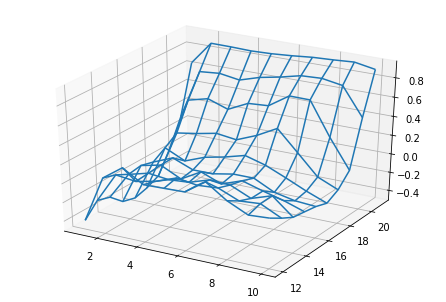

Q-value without Usable Ace


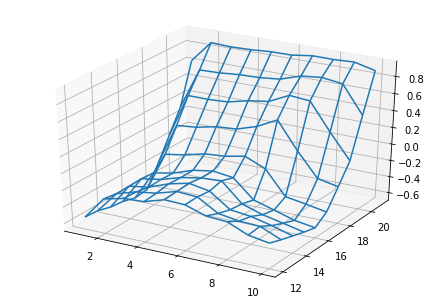

Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)


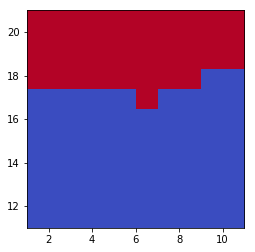

Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)


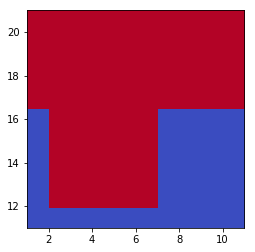

In [12]:
print("Q-value with Usable Ace")
plot_q_val(agent, usable_ace=True)
print("Q-value without Usable Ace")
plot_q_val(agent, usable_ace=False)
print("Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)")
usable_result = plot_action(agent, usable_ace=True)
print("Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)")
no_usable_result = plot_action(agent, usable_ace=False)

----
## 9. 과제

### 목표 
위 코드로부터 최적 Policy를 학습시킨 Agent를 사용하여, 블랙잭 게임을 시뮬레이션한 뒤 승률을 계산.

### 초기 설정
 - 플레이어는 1,000,000번의 에피소드로부터 최적 Policy를 학습
 - 플레이어의 초기 자금 : 10,000 달러
 - 플레이어는 게임 참가 시 10 달러를 지불, 결과에 따라 금액을 획득
     - 승리 시 : 20 달러 획득
     - 무승부 시 : 10 달러 획득
     - 패배 시 : 0 달러 획득

### 요구사항
 - 플레이어와 딜러가 1,000번의 게임을 진행
 - 1,000번의 게임 후 플레이어의 승률을 계산
 - 매 게임 별 플레이어의 소지금 변화를 그래프로 시각화

#### * HINT : MonteCarlo 클래스의 generate_episode(), train() 메소드를 참고할 것
----
### (과제 1) 1,000번의 게임 진행

In [10]:
############### 코드 작성 ##############################

# Class 몬테카를로에 realgame 함수를 생성, q테이블을 업데이트하지않고 해당 테이블을 계속해서 사용하는 함수를 생성하여 실행하였습니다.


mc_es.realgame(dealer, agent, deck, it=1000)
            

########################################################

========== Training : Episode  100  ===========
Recent 100 games win rate :33.684%
 -- 100 Games WIN : 32 DRAW : 5 LOSS : 63
Total win rate : 33.684%
Agent's Current Money : 9690
 -- TOTAL Games WIN : 32 DRAW : 5 LOSS : 63
========== Training : Episode  200  ===========
Recent 100 games win rate :33.511%
 -- 100 Games WIN : 63 DRAW : 12 LOSS : 125
Total win rate : 33.569%
Agent's Current Money : 9380
 -- TOTAL Games WIN : 95 DRAW : 17 LOSS : 188
========== Training : Episode  300  ===========
Recent 100 games win rate :35.018%
 -- 100 Games WIN : 97 DRAW : 23 LOSS : 180
Total win rate : 34.286%
Agent's Current Money : 9170
 -- TOTAL Games WIN : 192 DRAW : 40 LOSS : 368
========== Training : Episode  400  ===========
Recent 100 games win rate :35.849%
 -- 100 Games WIN : 133 DRAW : 29 LOSS : 238
Total win rate : 34.909%
Agent's Current Money : 8950
 -- TOTAL Games WIN : 325 DRAW : 69 LOSS : 606
========== Training : Episode  500  ===========
Recent 100 games win rate :37.527%
 -- 100 Ga

### (과제 2) 플레이어의 승률을 계산

In [63]:
############### 코드 작성 ##############################


print(agent.winrate)



########################################################

37.87234042553192


### (과제 3) 플레이어의 소지금 변화를 그래프로 시각화

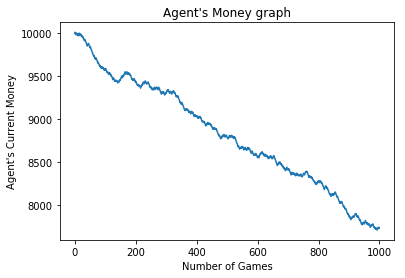

In [68]:
############### 코드 작성 ##############################

def plot_money(agent: Agent):
    
    plt.plot(agent.M_table)
    plt.xlabel('Number of Games')
    plt.ylabel("Agent's Current Money")
    plt.title("Agent's Money graph")
    plt.show()
    
plot_money(agent)


########################################################

## 추가 과제 : 플레이어의 승률 높이기
State를 수정하여 승률이 더 높은 policy를 찾기

기존 코드의 수정 필요
 - 딜러는 게임이 끝났을 때, 남은 카드의 수를 확인
 - 15장 이상이라면 해당 덱을 다음 게임에서 그대로 사용
 - 15장 미만이라면 52장의 셔플된 새로운 카드를 기존 덱에 추가



In [ ]:
############### 코드 작성 ##############################






########################################################

---
### 참고자료
[1] Reinforcement Learning - An Introduction (Richard S. Sutton, Andreow G. Barto), 2nd edition, p.120-124 https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf <br>
[2] matplotlib.pyplot.plot Documentation, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html <br>
[3] matplotlib.pyplot.plot Examples https://matplotlib.org/tutorials/introductory/pyplot.html